<a href="https://colab.research.google.com/github/raulsomazabracho/Data-From-API/blob/main/Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este script nos conectaremos a la API de Spotify para poder sacar información de ahi y poder trabajar con ella

PARA PERSONAL UTILIZAREMOS ESTOS 2: 
https://towardsdatascience.com/visualizing-spotify-data-with-python-tableau-687f2f528cdd

https://towardsdatascience.com/spotify-api-audio-features-5d8bcbd780b2

# Importamos las librerias

In [ ]:
pip install fsspec

In [ ]:
#Importamos librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json
import datetime
import base64
from urllib.parse import urlencode
from pandas.io.json import json_normalize

# Conexión a la API

## Creacion de llave, usuario y credenciales

Para poder conectarnos tenemos que crear una applicacion dentro de la plataforma de spotify y aceptar todos los permisos:
https://developer.spotify.com/dashboard/applications/5360540fd7404409b61be845bc0a308e

In [ ]:
#Client_ID y User

client_id= '5360540fd7404409b61be845bc0a308e'
client_secret = 'c2723081247e4a6db55a175ab2543b3e'

#las credenciales son del tipo base64 por lo que hay que convertirlas
client_creds = f'{client_id}:{client_secret}'
client_creds_64 = base64.b64encode(client_creds.encode())

token_url = 'https://accounts.spotify.com/api/token'
metod = 'POST'
token_data ={'grant_type':'client_credentials','scope':'user-top-read'}
token_headers = {'Authorization':f'Basic {client_creds_64.decode()}'}

## Request

In [ ]:
#Hacemos el request a la api para generar el tokem
r = requests.post(token_url,data=token_data,headers = token_headers)
print(r)

<Response [200]>


Guardamos el token generado

Como el token cabia cada hora hay que refrescarlo

In [ ]:
token_response_data = r.json()
print(token_response_data)
access_token = token_response_data['access_token']
scope = token_response_data['scope']
expires_in = token_response_data['expires_in']

{'access_token': 'BQDbVECrbco-zZXsFRSTjwrqQkkcN2mSbVHxehWVlG0ITT8wtj54hWJIEI-BBMkx_K2Op4jnV0xOs02Zs9VxoR7vupQ', 'token_type': 'Bearer', 'expires_in': 3600, 'scope': 'user-top-read'}


#Utilizamos El Access Token

## Consolidado Canciones 1 (Benee)

In [ ]:
#Headers --> la autizacion generada ocn el token que solicitamos antes
headers = {
    "Authorization": f"Bearer {access_token}"
}
endpoint = 'https://api.spotify.com/v1/artists/0Cp8WN4V8Tu4QJQwCN5Md4/albums'#ver todas las canciones de Benee
data = urlencode({'market':'US'}) # transformamos ese diccionario en url, si no se le asgina mercado no se puede extraer
print(data)
#creamos la url a la cual conectarnos
lookup_url = f'{endpoint}?{data}'
print(lookup_url)
#Sacamos el request y vemos si es aceptado
r2 = requests.get(lookup_url, headers = headers, params = { 'limit': 50}) #Queremos 50 canciones
print(r2)

#Lo transformamos en json
r2 = r2.json()

market=US
https://api.spotify.com/v1/artists/0Cp8WN4V8Tu4QJQwCN5Md4/albums?market=US
<Response [200]>


In [ ]:
#Observamos los distintos albums del artista, para luego iterar sobre ellos y obtener la info
for album in r2['items']:
    print(album['name'], ' --- ', album['release_date'])

Hey u x  ---  2020-11-13
Hey u x  ---  2020-11-13
Doesn't Matter  ---  2021-10-27
ARE YOU LETTING GO? (feat. BENEE)  ---  2021-10-21
Somebody That I Used To Know  ---  2021-10-15
help herself (with BENEE)  ---  2021-04-30
Back To Black  ---  2020-11-12
C U (For Nest Audio Sessions)  ---  2020-11-12
Supalonely (Lownely)  ---  2020-05-05
Supalonely (Lownely)  ---  2020-05-05
STELLA & STEVE  ---  2019-11-15
STELLA & STEVE  ---  2019-11-15
FIRE ON MARZZ  ---  2019-06-28
Tough Guy  ---  2017-12-08
未来流行动脉  ---  2021-12-20
Z世代欧美金嗓  ---  2021-12-16
欧美小众精选  ---  2021-12-16
Year Of The Tiger  ---  2021-12-14
Bedroom Pop  ---  2021-12-13
The Hating Game (Original Motion Picture Soundtrack)  ---  2021-12-10
The Hating Game (Original Motion Picture Soundtrack)  ---  2021-12-10
As Favoritas de 2020  ---  2021-12-10
洗脑疯狂节拍  ---  2021-12-07
Best Of 2021: Breakout Artists  ---  2021-12-06
Kids Dance Party Music  ---  2021-12-03
Best Of 2021: Indie Alternative  ---  2021-12-03
Lost In Life  ---  2021-12

In [ ]:
#Creamos variables donde se guardará la data proximamente
BASE_URL = 'https://api.spotify.com/v1/'
data = []
albums = [] # eso es para eliminar aquillos que aparece repetidos

for album in r2['items']:
  nombre_album = album['name']

  # con este hack podemos eliminar repetidos
  trim_name = nombre_album.split('(')[0].strip()
  if trim_name.upper() in albums or album['name'] !='Hey u x' and album['name'] !='STELLA & STEVE' and album['name'] !='FIRE ON MARZZ' and album['name'] !='Tough Guy' and album['name'] !='Back To Black' and album['name'] !='help herself (with BENEE)' and album['name'] !='Somebody That I Used To Know' and album['name'] !='ARE YOU LETTING GO? (feat. BENEE)' and album['name'] !='Supalonely (Lownely)' and album['name'] !="Doesn't Matter" and album['name'] != 'C U (For Nest Audio Sessions)' : #Evitar albumes repetidos
      continue

  #Ahora si a traer la info:    
  albums.append(trim_name.upper()) # use upper() to standardize
  print(nombre_album)
  print(album['id'])

  # nos traemos la info de cada cancion dentro del album
  r3 = requests.get(BASE_URL + 'albums/' + album['id'] + '/tracks', 
        headers=headers)
  tracks = r3.json()

  #Nos traemos la info de sonido dentro de cada cancion
  for track in tracks['items']:
    f = requests.get(BASE_URL + 'audio-features/' + track['id'], headers=headers)
    f = f.json()
    #Nos traemos tambien la popularidad de la cancione 
    s = requests.get(BASE_URL + 'tracks/' + track['id'], headers=headers)
    s = s.json()
    #s.update({
    #    'popularity':track['popularity']
    # })
    
    # combinamos con la info del album
    f.update({
    'track_name': track['name'],
    'album_name': nombre_album,
    'short_album_name': trim_name,
    'release_date': album['release_date'],
    'album_id': album['id'],
    'popularity':s['popularity'],
    'explicit': s['explicit']
     })
    

    data.append(f)
    print("Ok la cancion: ", track['name'])

Hey u x
4KKRAmQ0ksj32l7mrgLOcF
Ok la cancion:  Happen To Me
Ok la cancion:  Same Effect
Ok la cancion:  Sheesh (feat. Grimes)
Ok la cancion:  Supalonely (feat. Gus Dapperton)
Ok la cancion:  Snail
Ok la cancion:  Plain (feat. Lily Allen & Flo Milli)
Ok la cancion:  Kool
Ok la cancion:  Winter (feat. Mallrat)
Ok la cancion:  A Little While
Ok la cancion:  Night Garden (feat. Kenny Beats & Bakar)
Ok la cancion:  All The Time (feat. Muroki)
Ok la cancion:  If I Get To Meet You
Ok la cancion:  C U
Doesn't Matter
25JTMiXU4RhSWbcRDr5uLV
Ok la cancion:  Doesn't Matter
ARE YOU LETTING GO? (feat. BENEE)
4XbYHifFUBdVizgBN4wSmI
Ok la cancion:  ARE YOU LETTING GO? (feat. BENEE)
Ok la cancion:  KEEP THE PACE
Somebody That I Used To Know
6Bvt9VOWArLCq7n5aqIJEU
Ok la cancion:  Somebody That I Used to Know
help herself (with BENEE)
1dtiE9k4fY5xKRb4r80NKa
Ok la cancion:  help herself (with BENEE)
Back To Black
594QOTgYUnFesTBYXPHWB7
Ok la cancion:  Back To Black
C U (For Nest Audio Sessions)
3cJGmZzpJk

In [ ]:
#Creamos el dataframe con la data
df = pd.DataFrame(data)
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'track_name', 'album_name', 'short_album_name',
       'release_date', 'album_id', 'popularity', 'explicit'],
      dtype='object')

In [ ]:
#Odenamos por fecha
df['release_date'] = pd.to_datetime(df['release_date'])
df = df.sort_values(by='release_date')

#Eliminamos en vivos/remixes y eso
df = df[~df['track_name'].str.contains('Live|Mix|Track')]

In [ ]:
df.to_csv('Benee.csv', index = False)
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,track_name,album_name,short_album_name,release_date,album_id,popularity,explicit
32,0.513,0.624,5,-5.882,0,0.0599,0.28900,0.000018,0.1350,0.552,74.421,audio_features,5kFHgvYq9KkYJQx9h08b2c,spotify:track:5kFHgvYq9KkYJQx9h08b2c,https://api.spotify.com/v1/tracks/5kFHgvYq9KkY...,https://api.spotify.com/v1/audio-analysis/5kFH...,229707,4,Tough Guy,Tough Guy,Tough Guy,2017-12-08,26gG47QJC08DHHtnzuKnZb,46,False
30,0.826,0.635,6,-5.844,0,0.1060,0.30900,0.000000,0.1390,0.538,105.971,audio_features,0jeJE3TUJ5FrRuVLr7w4JQ,spotify:track:0jeJE3TUJ5FrRuVLr7w4JQ,https://api.spotify.com/v1/tracks/0jeJE3TUJ5Fr...,https://api.spotify.com/v1/audio-analysis/0jeJ...,153213,4,Evil Spider,FIRE ON MARZZ,FIRE ON MARZZ,2019-06-28,6pTMhQX8gt1xegiIwo3Ekb,55,False
29,0.824,0.629,10,-5.714,1,0.0333,0.30900,0.000000,0.0927,0.740,109.968,audio_features,5WssbEU2WtMHm7NH37Nfz5,spotify:track:5WssbEU2WtMHm7NH37Nfz5,https://api.spotify.com/v1/tracks/5WssbEU2WtMH...,https://api.spotify.com/v1/audio-analysis/5Wss...,236760,4,Afterlife,FIRE ON MARZZ,FIRE ON MARZZ,2019-06-28,6pTMhQX8gt1xegiIwo3Ekb,52,False
28,0.644,0.661,4,-6.161,1,0.0332,0.14400,0.000002,0.1770,0.550,82.022,audio_features,06Xh1KvQofFghlSt33mFjc,spotify:track:06Xh1KvQofFghlSt33mFjc,https://api.spotify.com/v1/tracks/06Xh1KvQofFg...,https://api.spotify.com/v1/audio-analysis/06Xh...,213373,4,Wishful Thinking,FIRE ON MARZZ,FIRE ON MARZZ,2019-06-28,6pTMhQX8gt1xegiIwo3Ekb,64,False
27,0.801,0.589,7,-5.157,1,0.0485,0.08630,0.000000,0.1620,0.580,116.934,audio_features,23TPP1eeElFfvYVznskwCY,spotify:track:23TPP1eeElFfvYVznskwCY,https://api.spotify.com/v1/tracks/23TPP1eeElFf...,https://api.spotify.com/v1/audio-analysis/23TP...,180147,4,Glitter,FIRE ON MARZZ,FIRE ON MARZZ,2019-06-28,6pTMhQX8gt1xegiIwo3Ekb,70,False
26,0.793,0.588,9,-5.248,0,0.0353,0.46400,0.000000,0.1050,0.601,93.004,audio_features,4zIiarkbaDt2cm6sukb1Xt,spotify:track:4zIiarkbaDt2cm6sukb1Xt,https://api.spotify.com/v1/tracks/4zIiarkbaDt2...,https://api.spotify.com/v1/audio-analysis/4zIi...,240947,4,Soaked,FIRE ON MARZZ,FIRE ON MARZZ,2019-06-28,6pTMhQX8gt1xegiIwo3Ekb,63,False
31,0.541,0.646,9,-6.451,1,0.2260,0.55800,0.001450,0.1010,0.470,84.832,audio_features,7IoV5eGR85wUOXjninlmNu,spotify:track:7IoV5eGR85wUOXjninlmNu,https://api.spotify.com/v1/tracks/7IoV5eGR85wU...,https://api.spotify.com/v1/audio-analysis/7IoV...,234040,4,Want Me Back,FIRE ON MARZZ,FIRE ON MARZZ,2019-06-28,6pTMhQX8gt1xegiIwo3Ekb,57,False
25,0.743,0.593,1,-4.531,0,0.0263,0.13800,0.002220,0.4660,0.516,99.970,audio_features,18piLjvom24Ub9c2IxTHSx,spotify:track:18piLjvom24Ub9c2IxTHSx,https://api.spotify.com/v1/tracks/18piLjvom24U...,https://api.spotify.com/v1/audio-analysis/18pi...,202400,4,Blu,STELLA & STEVE,STELLA & STEVE,2019-11-15,3ZJSoxsPMkNC9eb6gUn0Q8,51,False
24,0.770,0.688,1,-6.000,1,0.0350,0.01190,0.007860,0.1070,0.406,100.006,audio_features,00uJ2qNYu1EzaHjNRa9W6b,spotify:track:00uJ2qNYu1EzaHjNRa9W6b,https://api.spotify.com/v1/tracks/00uJ2qNYu1Ez...,https://api.spotify.com/v1/audio-analysis/00uJ...,203893,4,Drifting,STELLA & STEVE,STELLA & STEVE,2019-11-15,3ZJSoxsPMkNC9eb6gUn0Q8,48,False
23,0.595,0.670,1,-4.879,0,0.1970,0.03380,0.000030,0.1160,0.667,219.378,audio_features,2dZ6qbPiSoemJYoFWv9e0e,spotify:track:2dZ6qbPiSoemJYoFWv9e0e,https://api.spotify.com/v1/tracks/2dZ6qbPiSoem...,https://api.spotify.com/v1/audio-analysis/2dZ6...,221960,4,Monsta,STELLA & STEVE,STELLA & STEVE,2019-11-15,3ZJSoxsPMkNC9eb6gUn0Q8,52,False


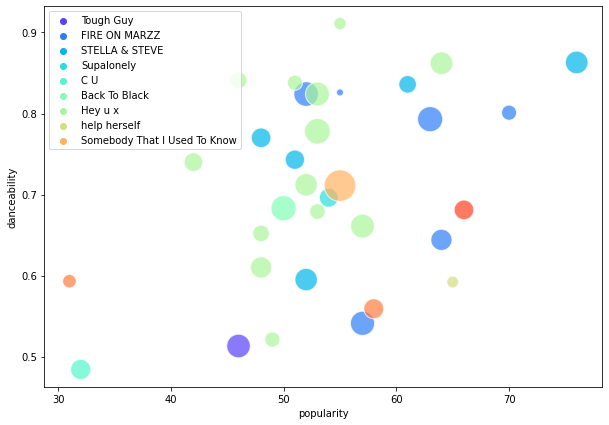

In [ ]:
#Graficamos 
plt.figure(figsize=(10,7))

ax = sns.scatterplot(data=df, x='popularity', y='danceability', 
                     hue='short_album_name', palette='rainbow', 
                     size='duration_ms', sizes=(50,1000), 
                     alpha=0.7)

# display legend without `size` attribute
h,labs = ax.get_legend_handles_labels()
ax.legend(h[1:10], labs[1:10], loc='best', title=None)

La musica de benee se considera del estilo bailable y la que que es menos bailable es justamente la menos popular

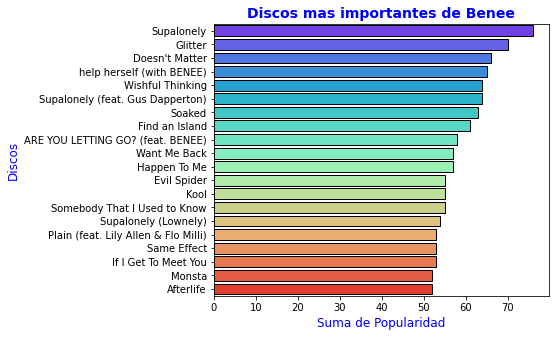

In [ ]:
#Popularidad del album
fig, ax = plt.subplots(figsize = (6, 5))
lead_track = df.groupby('track_name')['popularity'].sum().sort_values(ascending=False).head(20)
ax = sns.barplot(x=lead_track.values, y=lead_track.index, palette="rainbow", orient="h", edgecolor='black', ax=ax)
ax.set_xlabel('Suma de Popularidad', c='b', fontsize=12)
ax.set_ylabel('Discos', c='b', fontsize=12)
ax.set_title('Discos mas importantes de Benee', c='b', fontsize=14, weight = 'bold')
plt.show()

Se ve que la cancion mas popular es supalonely, seguida de gliter y doesnt matter

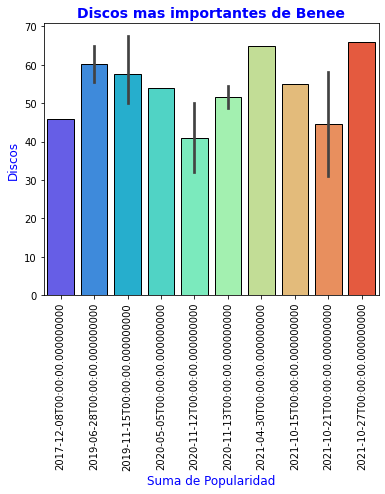

In [ ]:
#Popularidad del album
fig, ax = plt.subplots(figsize = (6, 5))
ax = sns.barplot(x=df.release_date, y=df.popularity, palette="rainbow", edgecolor='black', ax=ax)
ax.set_xlabel('Suma de Popularidad', c='b', fontsize=12)
plt.xticks(rotation=90)
ax.set_ylabel('Discos', c='b', fontsize=12)
ax.set_title('Discos mas importantes de Benee', c='b', fontsize=14, weight = 'bold')
plt.show()

El pico de popularidad fue alcanzado en el 2021

## Consolidado de canciones 2 (Coldplay)

In [ ]:
#Headers --> la autizacion generada ocn el token que solicitamos antes
headers = {
    "Authorization": f"Bearer {access_token}"
}
endpoint = 'https://api.spotify.com/v1/artists/4gzpq5DPGxSnKTe4SA8HAU/albums'#ver todas las canciones de Benee
data = urlencode({'market':'US'}) # transformamos ese diccionario en url, si no se le asgina mercado no se puede extraer
print(data)
#creamos la url a la cual conectarnos
lookup_url = f'{endpoint}?{data}'
print(lookup_url)
#Sacamos el request y vemos si es aceptado
r2 = requests.get(lookup_url, headers = headers, params = { 'limit': 50}) #Queremos 50 canciones
print(r2)

#Lo transformamos en json
r2 = r2.json()

market=US
https://api.spotify.com/v1/artists/4gzpq5DPGxSnKTe4SA8HAU/albums?market=US
<Response [200]>


In [ ]:
#Observamos los distintos albums del artista, para luego iterar sobre ellos y obtener la info
for album in r2['items']:
    print(album['name'], ' --- ', album['release_date'])

Music Of The Spheres  ---  2021-10-15
Everyday Life  ---  2019-11-22
Everyday Life  ---  2019-11-22
Everyday Life  ---  2019-11-22
Everyday Life  ---  2019-11-22
Live in Buenos Aires  ---  2018-12-07
Love in Tokyo  ---  2018-12-07
A Head Full of Dreams  ---  2015-12-04
A Head Full of Dreams Tour Edition  ---  2015-12-04
Ghost Stories Live 2014  ---  2014-11-21
Ghost Stories  ---  2014-05-19
Mylo Xyloto  ---  2011-10-24
Mylo Xyloto  ---  2011-10-24
Mylo Xyloto  ---  2011-10-19
LeftRightLeftRightLeft (Live)  ---  2009-05-15
Viva La Vida (Prospekt's March Edition)  ---  2008-11-24
Viva La Vida (Prospekt's March Edition)  ---  2008-11-24
Viva La Vida (Prospekt's March Edition)  ---  2008-11-24
Viva La Vida (Prospekt's March Edition)  ---  2008-11-24
Viva La Vida (Prospekt's March Edition)  ---  2008-11-24
Viva La Vida or Death and All His Friends  ---  2008-06-19
Viva La Vida or Death and All His Friends  ---  2008-06-19
Viva La Vida or Death and All His Friends  ---  2008-06-12
Viva La Vi

In [ ]:
#Creamos variables donde se guardará la data proximamente
BASE_URL = 'https://api.spotify.com/v1/'
data = []
albums = [] # eso es para eliminar aquillos que aparece repetidos

for album in r2['items']:
  nombre_album = album['name']

  # con este hack podemos eliminar repetidos
  trim_name = nombre_album.split('(')[0].strip()
  if trim_name.upper() in albums or album['id']!='2G4AUqfwxcV1UdQjm2ouYr' and album['id']!= '3cfAM8b8KqJRoIzt3zLKqw' and album['id'] != '06mXfvDsRZNfnsGZvX2zpb' and album['id'] !='2FeyIYDDAQqcOJKOKhvHdr' : #Evitar albumes repetidos
      continue

  #Ahora si a traer la info:    
  albums.append(trim_name.upper()) # use upper() to standardize
  print(nombre_album)
  print(album['id'])

  # nos traemos la info de cada cancion dentro del album
  r3 = requests.get(BASE_URL + 'albums/' + album['id'] + '/tracks', 
        headers=headers)
  tracks = r3.json()

  #Nos traemos la info de sonido dentro de cada cancion
  for track in tracks['items']:
    print("Estamos adjuntando:", track['name'])
    if track['name'] == 'O' :
      continue

    f = requests.get(BASE_URL + 'audio-features/' + track['id'], headers=headers)
    f = f.json()
    #Nos traemos tambien la popularidad de la cancione 
    s = requests.get(BASE_URL + 'tracks/' + track['id'], headers=headers)
    s = s.json()
    #s.update({
    #    'popularity':track['popularity']
    # })
    
    # combinamos con la info del album
    f.update({
    'track_name': track['name'],
    'album_name': nombre_album,
    'short_album_name': trim_name,
    'release_date': album['release_date'],
    'album_id': album['id'],
    'popularity':s['popularity'],
    'explicit': s['explicit']
     })
    

    data.append(f)
    print("Ok la cancion: ", track['name'])

Music Of The Spheres
06mXfvDsRZNfnsGZvX2zpb
Estamos adjuntando: 🪐
Ok la cancion:  🪐
Estamos adjuntando: Higher Power
Ok la cancion:  Higher Power
Estamos adjuntando: Humankind
Ok la cancion:  Humankind
Estamos adjuntando: ✨
Ok la cancion:  ✨
Estamos adjuntando: Let Somebody Go
Ok la cancion:  Let Somebody Go
Estamos adjuntando: ❤️
Ok la cancion:  ❤️
Estamos adjuntando: People of The Pride
Ok la cancion:  People of The Pride
Estamos adjuntando: Biutyful
Ok la cancion:  Biutyful
Estamos adjuntando: 🌎
Ok la cancion:  🌎
Estamos adjuntando: My Universe
Ok la cancion:  My Universe
Estamos adjuntando: ♾
Ok la cancion:  ♾
Estamos adjuntando: Coloratura
Ok la cancion:  Coloratura
Everyday Life
2FeyIYDDAQqcOJKOKhvHdr
Estamos adjuntando: Sunrise
Ok la cancion:  Sunrise
Estamos adjuntando: Church
Ok la cancion:  Church
Estamos adjuntando: Trouble In Town
Ok la cancion:  Trouble In Town
Estamos adjuntando: BrokEn
Ok la cancion:  BrokEn
Estamos adjuntando: Daddy
Ok la cancion:  Daddy
Estamos adjunta

In [ ]:
#Creamos el dataframe con la data
df1 = pd.DataFrame(data)
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'track_name', 'album_name', 'short_album_name',
       'release_date', 'album_id', 'popularity'],
      dtype='object')

In [ ]:
#Creamos variables donde se guardará la data proximamente
BASE_URL = 'https://api.spotify.com/v1/'
data = []
albums = [] # eso es para eliminar aquillos que aparece repetidos

for album in r2['items']:
  nombre_album = album['name']

  # con este hack podemos eliminar repetidos
  trim_name = nombre_album.split('(')[0].strip()
  if trim_name.upper() in albums or album['id']!='2R7iJz5uaHjLEVnMkloO18'and album['id'] != '1CEODgTmTwLyabvwd7HBty' and album['id']!='1CEODgTmTwLyabvwd7HBty' and album['id'] != '4E7bV0pzG0LciBSWTszra6' and album['id'] != '0RHX9XECH8IVI3LNgWDpmQ' : #vitar albumes repetidos
      continue

  #Ahora si a traer la info:    
  albums.append(trim_name.upper()) # use upper() to standardize
  print(nombre_album)
  print(album['id'])

  # nos traemos la info de cada cancion dentro del album
  r3 = requests.get(BASE_URL + 'albums/' + album['id'] + '/tracks', 
        headers=headers)
  tracks = r3.json()

  #Nos traemos la info de sonido dentro de cada cancion
  for track in tracks['items']:
    print("Estamos adjuntando:", track['name'])
    if track['name'] == 'O' :
      continue

    f = requests.get(BASE_URL + 'audio-features/' + track['id'], headers=headers)
    f = f.json()
    #Nos traemos tambien la popularidad de la cancione 
    s = requests.get(BASE_URL + 'tracks/' + track['id'], headers=headers)
    s = s.json()
    #s.update({
    #    'popularity':track['popularity']
    # })
    
    # combinamos con la info del album
    f.update({
    'track_name': track['name'],
    'album_name': nombre_album,
    'short_album_name': trim_name,
    'release_date': album['release_date'],
    'album_id': album['id'],
    'popularity':s['popularity'],
    'explicit': s['explicit']
     })
    

    data.append(f)
    print("Ok la cancion: ", track['name'])

#Creamos el dataframe con la data
df2 = pd.DataFrame(data)

Mylo Xyloto
2R7iJz5uaHjLEVnMkloO18
Estamos adjuntando: Mylo Xyloto
Ok la cancion:  Mylo Xyloto
Estamos adjuntando: Hurts Like Heaven
Ok la cancion:  Hurts Like Heaven
Estamos adjuntando: Paradise
Ok la cancion:  Paradise
Estamos adjuntando: Charlie Brown
Ok la cancion:  Charlie Brown
Estamos adjuntando: Us Against the World
Ok la cancion:  Us Against the World
Estamos adjuntando: M.M.I.X.
Ok la cancion:  M.M.I.X.
Estamos adjuntando: Every Teardrop Is a Waterfall
Ok la cancion:  Every Teardrop Is a Waterfall
Estamos adjuntando: Major Minus
Ok la cancion:  Major Minus
Estamos adjuntando: U.F.O.
Ok la cancion:  U.F.O.
Estamos adjuntando: Princess of China
Ok la cancion:  Princess of China
Estamos adjuntando: Up in Flames
Ok la cancion:  Up in Flames
Estamos adjuntando: A Hopeful Transmission
Ok la cancion:  A Hopeful Transmission
Estamos adjuntando: Don't Let It Break Your Heart
Ok la cancion:  Don't Let It Break Your Heart
Estamos adjuntando: Up with the Birds
Ok la cancion:  Up with the

In [ ]:
#Creamos variables donde se guardará la data proximamente
BASE_URL = 'https://api.spotify.com/v1/'
data = []
albums = [] # eso es para eliminar aquillos que aparece repetidos

for album in r2['items']:
  nombre_album = album['name']

  # con este hack podemos eliminar repetidos
  trim_name = nombre_album.split('(')[0].strip()
  if trim_name.upper() in albums or album['id']!='6ZG5lRT77aJ3btmArcykra' : #vitar albumes repetidos
      continue

  #Ahora si a traer la info:    
  albums.append(trim_name.upper()) # use upper() to standardize
  print(nombre_album)
  print(album['id'])

  # nos traemos la info de cada cancion dentro del album
  r3 = requests.get(BASE_URL + 'albums/' + album['id'] + '/tracks', 
        headers=headers)
  tracks = r3.json()

  #Nos traemos la info de sonido dentro de cada cancion
  for track in tracks['items']:
    print("Estamos adjuntando:", track['name'])
    if track['name'] == 'O' :
      continue

    f = requests.get(BASE_URL + 'audio-features/' + track['id'], headers=headers)
    f = f.json()
    #Nos traemos tambien la popularidad de la cancione 
    s = requests.get(BASE_URL + 'tracks/' + track['id'], headers=headers)
    s = s.json()
    #s.update({
    #    'popularity':track['popularity']
    # })
    
    # combinamos con la info del album
    f.update({
    'track_name': track['name'],
    'album_name': nombre_album,
    'short_album_name': trim_name,
    'release_date': album['release_date'],
    'album_id': album['id'],
    'popularity':s['popularity'],
    'explicit': s['explicit']
     })
    

    data.append(f)
    print("Ok la cancion: ", track['name'])

#Creamos el dataframe con la data
df3 = pd.DataFrame(data)

Parachutes
6ZG5lRT77aJ3btmArcykra
Estamos adjuntando: Don't Panic
Ok la cancion:  Don't Panic
Estamos adjuntando: Shiver
Ok la cancion:  Shiver
Estamos adjuntando: Spies
Ok la cancion:  Spies
Estamos adjuntando: Sparks
Ok la cancion:  Sparks
Estamos adjuntando: Yellow
Ok la cancion:  Yellow
Estamos adjuntando: Trouble
Ok la cancion:  Trouble
Estamos adjuntando: Parachutes
Ok la cancion:  Parachutes
Estamos adjuntando: High Speed
Ok la cancion:  High Speed
Estamos adjuntando: We Never Change
Ok la cancion:  We Never Change
Estamos adjuntando: Everything's Not Lost - Includes Hidden Track 'Life Is For Living'
Ok la cancion:  Everything's Not Lost - Includes Hidden Track 'Life Is For Living'


In [ ]:
#Odenamos por fecha
df = pd.concat([df1,df2,df3], ignore_index = True)
df['release_date'] = pd.to_datetime(df['release_date'])
df = df.sort_values(by='release_date')

#Eliminamos en vivos/remixes y eso
df = df[~df['track_name'].str.contains('Live|Mix|Track')]

In [ ]:
df.to_csv('Coldplay.csv', index = False)
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,track_name,album_name,short_album_name,release_date,album_id,popularity,explicit
95,0.602,0.612,0,-8.409,1,0.0335,0.20600,0.006070,0.1070,0.4530,122.062,audio_features,2QhURnm7mQDxBb5jWkbDug,spotify:track:2QhURnm7mQDxBb5jWkbDug,https://api.spotify.com/v1/tracks/2QhURnm7mQDx...,https://api.spotify.com/v1/audio-analysis/2QhU...,136867,4,Don't Panic,Parachutes,Parachutes,2000-07-10,6ZG5lRT77aJ3btmArcykra,67,False
96,0.396,0.803,4,-6.186,1,0.0487,0.03340,0.000000,0.0688,0.2860,116.705,audio_features,0qksx8mV28lztYIZ1om8ml,spotify:track:0qksx8mV28lztYIZ1om8ml,https://api.spotify.com/v1/tracks/0qksx8mV28lz...,https://api.spotify.com/v1/audio-analysis/0qks...,304200,3,Shiver,Parachutes,Parachutes,2000-07-10,6ZG5lRT77aJ3btmArcykra,67,False
97,0.309,0.673,1,-5.524,0,0.0319,0.02360,0.000144,0.0635,0.0732,147.599,audio_features,2mLgOcRkEgq89j8WstUpui,spotify:track:2mLgOcRkEgq89j8WstUpui,https://api.spotify.com/v1/tracks/2mLgOcRkEgq8...,https://api.spotify.com/v1/audio-analysis/2mLg...,318773,4,Spies,Parachutes,Parachutes,2000-07-10,6ZG5lRT77aJ3btmArcykra,60,False
98,0.371,0.268,1,-10.506,1,0.0281,0.74800,0.051700,0.1040,0.1650,102.617,audio_features,7D0RhFcb3CrfPuTJ0obrod,spotify:track:7D0RhFcb3CrfPuTJ0obrod,https://api.spotify.com/v1/tracks/7D0RhFcb3Crf...,https://api.spotify.com/v1/audio-analysis/7D0R...,227093,3,Sparks,Parachutes,Parachutes,2000-07-10,6ZG5lRT77aJ3btmArcykra,82,False
103,0.433,0.288,6,-10.801,0,0.0296,0.53500,0.000169,0.1050,0.1310,136.939,audio_features,5TB6QgrF0RPIxSCGfRDLoe,spotify:track:5TB6QgrF0RPIxSCGfRDLoe,https://api.spotify.com/v1/tracks/5TB6QgrF0RPI...,https://api.spotify.com/v1/audio-analysis/5TB6...,249400,3,We Never Change,Parachutes,Parachutes,2000-07-10,6ZG5lRT77aJ3btmArcykra,62,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,0.115,0.907,3,-20.358,1,0.2230,0.96900,0.981000,0.9800,0.0185,189.885,audio_features,0RbekAlUrwR6ZWJdwB3V4y,spotify:track:0RbekAlUrwR6ZWJdwB3V4y,https://api.spotify.com/v1/tracks/0RbekAlUrwR6...,https://api.spotify.com/v1/audio-analysis/0Rbe...,21388,3,🌎,Music Of The Spheres,Music Of The Spheres,2021-10-15,06mXfvDsRZNfnsGZvX2zpb,19,False
10,0.576,0.896,2,-8.994,1,0.0412,0.00941,0.955000,0.1530,0.4120,135.010,audio_features,2wleRXcIPqltoDPLMH5WDa,spotify:track:2wleRXcIPqltoDPLMH5WDa,https://api.spotify.com/v1/tracks/2wleRXcIPqlt...,https://api.spotify.com/v1/audio-analysis/2wle...,226141,4,♾,Music Of The Spheres,Music Of The Spheres,2021-10-15,06mXfvDsRZNfnsGZvX2zpb,64,False
11,0.285,0.265,2,-10.836,1,0.0288,0.62900,0.179000,0.0660,0.0699,134.055,audio_features,0jH7gF7KCk2Lom9gimaKms,spotify:track:0jH7gF7KCk2Lom9gimaKms,https://api.spotify.com/v1/tracks/0jH7gF7KCk2L...,https://api.spotify.com/v1/audio-analysis/0jH7...,617057,4,Coloratura,Music Of The Spheres,Music Of The Spheres,2021-10-15,06mXfvDsRZNfnsGZvX2zpb,65,False
6,0.432,0.613,4,-6.785,0,0.0349,0.00581,0.015100,0.3120,0.0911,136.362,audio_features,5ophZLHA9mwSZhQSmboyDN,spotify:track:5ophZLHA9mwSZhQSmboyDN,https://api.spotify.com/v1/tracks/5ophZLHA9mwS...,https://api.spotify.com/v1/audio-analysis/5oph...,217267,4,People of The Pride,Music Of The Spheres,Music Of The Spheres,2021-10-15,06mXfvDsRZNfnsGZvX2zpb,67,True


## Consolidado de canciones 3 (Oasis)

In [ ]:
#Headers --> la autizacion generada ocn el token que solicitamos antes
headers = {
    "Authorization": f"Bearer {access_token}"
}
endpoint = 'https://api.spotify.com/v1/artists/2DaxqgrOhkeH0fpeiQq2f4/albums'#ver todas las canciones de Benee
data = urlencode({'market':'US'}) # transformamos ese diccionario en url, si no se le asgina mercado no se puede extraer
print(data)
#creamos la url a la cual conectarnos
lookup_url = f'{endpoint}?{data}'
print(lookup_url)
#Sacamos el request y vemos si es aceptado
r2 = requests.get(lookup_url, headers = headers, params = { 'include_groups': 'album','limit': 50}) #Queremos 50 canciones
print(r2)

#Lo transformamos en json
r2 = r2.json()

market=US
https://api.spotify.com/v1/artists/2DaxqgrOhkeH0fpeiQq2f4/albums?market=US
<Response [200]>


In [ ]:
#Observamos los distintos albums del artista, para luego iterar sobre ellos y obtener la info
for album in r2['items']:
    print(album['name'], ' --- ', album['release_date'])

Knebworth 1996 (Live)  ---  2021-11-19
Oasis Knebworth 1996  ---  2021-11-19
Knebworth 1996 (Live)  ---  2021-11-19
Be Here Now(Remastered)  ---  2016-10-14
Be Here Now(Remastered)(Deluxe Edition)  ---  2016-10-05
(What's The Story) Morning Glory (Remastered, Deluxe)  ---  2014-09-24
(What's The Story) Morning Glory (Remastered)  ---  2014-09-24
Definitely Maybe (Remastered)  ---  2014-05-14
Definitely Maybe (Remastered)  ---  2014-05-14
Time Flies… (1994 - 2009)  ---  2010-06-14
Time Flies...1994-2009  ---  2010
Dig Out Your Soul  ---  2008-10-06
Dig Out Your Soul  ---  2008-10-06
Dig Out Your Soul  ---  2008-10-06
Dig Out Your Soul  ---  2008-10-06
Dig Out Your Soul  ---  2008-10-04
Dig Out Your Soul  ---  2008-10-03
Dig Out Your Soul  ---  2008-10-01
Stop The Clocks  ---  2006-11-20
Stop The Clocks  ---  2006
Don't Believe The Truth  ---  2005-05-31
Don't Believe The Truth  ---  2005-05-30
Don't Believe The Truth  ---  2005-05-30
Don't Believe The Truth  ---  2005-05-25
Don't Believ

In [ ]:
#Creamos variables donde se guardará la data proximamente
BASE_URL = 'https://api.spotify.com/v1/'
data = []
albums = [] # eso es para eliminar aquillos que aparece repetidos

for album in r2['items']:
  nombre_album = album['name']

  # con este hack podemos eliminar repetidos
  trim_name = nombre_album.split('(')[0].strip()
  if trim_name.upper() in albums or album['name'] != 'Dig Out Your Soul' and album['name'] != "Don't Believe The Truth" and album['name'] != 'Heathen Chemistry'  and album['name'] != 'Standing On The Shoulder Of Giants' and album['name'] != 'The Masterplan' and album['name'] != "(What's The Story) Morning Glory? [Remastered]" and album['name'] != 'Definitely Maybe (Remastered)' and album['name'] != 'Be Here Now(Remastered)' or album['id'] == '00hodZxXjxj2OZ7WYKbLiT' or album['id'] == '0AN2qgKYhTdPkqacoTXQim': #ya que osasis se separó en 2009
      continue

  #Ahora si a traer la info:    
  albums.append(trim_name.upper()) # use upper() to standardize
  print(nombre_album)
  print(album['id'])

  # nos traemos la info de cada cancion dentro del album
  r3 = requests.get(BASE_URL + 'albums/' + album['id'] + '/tracks', 
        headers=headers)
  tracks = r3.json()

  #Nos traemos la info de sonido dentro de cada cancion
  for track in tracks['items']:
    if track['name'] == "I'm Outta Time" or track['name'] == '(Get Off Your) High Horse Lady'or track['name']== "To Be Where There's Life" or track['name']== 'Part Of The Queue' or track['name'] == 'Keep The Dream Alive' or track['name'] == 'A Bell Will Ring':
      continue

    print("Integrando la cancion: ", track['name'] )
    f = requests.get(BASE_URL + 'audio-features/' + track['id'], headers=headers)
    f = f.json()
    #Nos traemos tambien la popularidad de la cancione 
    s = requests.get(BASE_URL + 'tracks/' + track['id'], headers=headers)
    s = s.json()
    #s.update({
  #      'popularity':track[]
  #  })
    
    # combinamos con la info del album
    f.update({
    'track_name': track['name'],
    'album_name': nombre_album,
    'short_album_name': trim_name,
    'release_date': album['release_date'],
    'album_id': album['id'],
    'popularity': s['popularity']
     })
    

    data.append(f)
    print("Ok la cancion: ", track['name'])

Be Here Now(Remastered)
4BCOxFkJvT2WCSgh3ng74W
Integrando la cancion:  D'You Know What I Mean? - Remastered
Ok la cancion:  D'You Know What I Mean? - Remastered
Integrando la cancion:  My Big Mouth - Remastered
Ok la cancion:  My Big Mouth - Remastered
Integrando la cancion:  Magic Pie - Remastered
Ok la cancion:  Magic Pie - Remastered
Integrando la cancion:  Stand by Me - Remastered
Ok la cancion:  Stand by Me - Remastered
Integrando la cancion:  I Hope, I Think, I Know - Remastered
Ok la cancion:  I Hope, I Think, I Know - Remastered
Integrando la cancion:  The Girl in the Dirty Shirt - Remastered
Ok la cancion:  The Girl in the Dirty Shirt - Remastered
Integrando la cancion:  Fade In-Out - Remastered
Ok la cancion:  Fade In-Out - Remastered
Integrando la cancion:  Don't Go Away - Remastered
Ok la cancion:  Don't Go Away - Remastered
Integrando la cancion:  Be Here Now - Remastered
Ok la cancion:  Be Here Now - Remastered
Integrando la cancion:  All Around the World - Remastered
Ok 

KeyError: ignored

In [ ]:
#Creamos el dataframe con la data
df = pd.DataFrame(data)
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'track_name', 'album_name', 'short_album_name',
       'release_date', 'album_id', 'popularity'],
      dtype='object')

In [ ]:

#Odenamos por fecha
df['release_date'] = pd.to_datetime(df['release_date'])
df = df.sort_values(by='release_date')

#Eliminamos en vivos/remixes y eso
df = df[~df['track_name'].str.contains('Live')]

In [ ]:
df.to_csv('Oasis.csv', index = False)
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,track_name,album_name,short_album_name,release_date,album_id,popularity
97,0.204,0.928,7,-3.274,1,0.0795,0.009740,0.000746,0.334,0.2090,112.864,audio_features,11JIdNpBagg6G0NHLDm2v2,spotify:track:11JIdNpBagg6G0NHLDm2v2,https://api.spotify.com/v1/tracks/11JIdNpBagg6...,https://api.spotify.com/v1/audio-analysis/11JI...,267987,4,Acquiesce - Remastered,(What's The Story) Morning Glory? [Remastered],,1995-10-02,1VW1MFNstaJuygaoTPkdCk,48
84,0.162,0.947,9,-3.174,0,0.1130,0.014200,0.044600,0.166,0.0563,132.310,audio_features,2LmwUKeGCJZUKHKwOrX3Xb,spotify:track:2LmwUKeGCJZUKHKwOrX3Xb,https://api.spotify.com/v1/tracks/2LmwUKeGCJZU...,https://api.spotify.com/v1/audio-analysis/2Lmw...,203187,4,Hello - Remastered,(What's The Story) Morning Glory? [Remastered],,1995-10-02,1VW1MFNstaJuygaoTPkdCk,46
85,0.232,0.986,9,-1.896,0,0.0947,0.032500,0.000311,0.117,0.1450,126.555,audio_features,05CNnC9ugYgnJgg6fIgyeQ,spotify:track:05CNnC9ugYgnJgg6fIgyeQ,https://api.spotify.com/v1/tracks/05CNnC9ugYgn...,https://api.spotify.com/v1/audio-analysis/05CN...,240093,4,Roll with It - Remastered,(What's The Story) Morning Glory? [Remastered],,1995-10-02,1VW1MFNstaJuygaoTPkdCk,50
86,0.378,0.896,2,-4.066,1,0.0407,0.000452,0.000000,0.194,0.4690,174.302,audio_features,5qqabIl2vWzo9ApSC317sa,spotify:track:5qqabIl2vWzo9ApSC317sa,https://api.spotify.com/v1/tracks/5qqabIl2vWzo...,https://api.spotify.com/v1/audio-analysis/5qqa...,258773,4,Wonderwall - Remastered,(What's The Story) Morning Glory? [Remastered],,1995-10-02,1VW1MFNstaJuygaoTPkdCk,79
87,0.327,0.938,0,-3.237,1,0.0645,0.070800,0.000004,0.148,0.3260,162.937,audio_features,0UvCh63URrLFcPkKt99hHd,spotify:track:0UvCh63URrLFcPkKt99hHd,https://api.spotify.com/v1/tracks/0UvCh63URrLF...,https://api.spotify.com/v1/audio-analysis/0UvC...,289560,4,Don't Look Back in Anger - Remastered,(What's The Story) Morning Glory? [Remastered],,1995-10-02,1VW1MFNstaJuygaoTPkdCk,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,0.460,0.944,9,-1.945,1,0.0458,0.079500,0.477000,0.546,0.2870,112.201,audio_features,1R6paNNiqBaB62GpAMpeuV,spotify:track:1R6paNNiqBaB62GpAMpeuV,https://api.spotify.com/v1/tracks/1R6paNNiqBaB...,https://api.spotify.com/v1/audio-analysis/1R6p...,312907,4,Be Here Now - Remastered,Be Here Now(Remastered),Be Here Now,2016-10-14,4BCOxFkJvT2WCSgh3ng74W,0
9,0.333,0.831,9,-3.149,1,0.0506,0.135000,0.000478,0.696,0.3260,82.101,audio_features,1bYkNQBsi8Jxxr4hzvDQzf,spotify:track:1bYkNQBsi8Jxxr4hzvDQzf,https://api.spotify.com/v1/tracks/1bYkNQBsi8Jx...,https://api.spotify.com/v1/audio-analysis/1bYk...,559200,4,All Around the World - Remastered,Be Here Now(Remastered),Be Here Now,2016-10-14,4BCOxFkJvT2WCSgh3ng74W,0
11,0.303,0.823,2,-5.115,1,0.0499,0.002790,0.825000,0.312,0.2190,82.006,audio_features,2gPRrzzAUExoOtG96fSFnz,spotify:track:2gPRrzzAUExoOtG96fSFnz,https://api.spotify.com/v1/tracks/2gPRrzzAUExo...,https://api.spotify.com/v1/audio-analysis/2gPR...,129640,4,All Around the World (Reprise) - Remastered,Be Here Now(Remastered),Be Here Now,2016-10-14,4BCOxFkJvT2WCSgh3ng74W,0
6,0.382,0.781,7,-4.122,1,0.0425,0.090100,0.019800,0.416,0.1950,86.210,audio_features,52TYSZtSZGpxdZbIVsHrNd,spotify:track:52TYSZtSZGpxdZbIVsHrNd,https://api.spotify.com/v1/tracks/52TYSZtSZGpx...,https://api.spotify.com/v1/audio-analysis/52TY...,411360,4,Fade In-Out - Remastered,Be Here Now(Remastered),Be Here Now,2016-10-14,4BCOxFkJvT2WCSgh3ng74W,0


Quiero observar que tan feliz-triste es la musica con valence [0,1] de triste a feliz va lo acustico
Colorando el album y el tamaño va a ser la longitud de la cancion

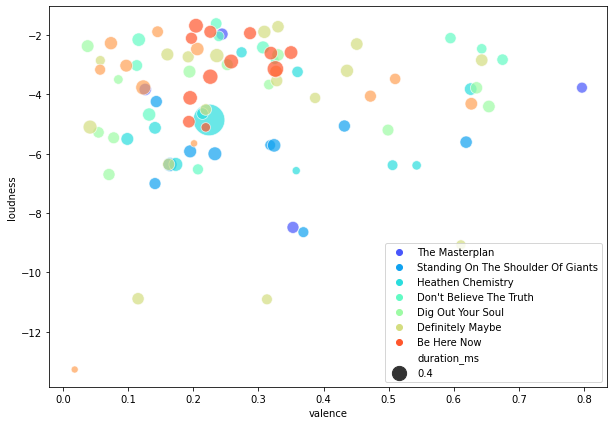

In [ ]:
#Graficamos 
plt.figure(figsize=(10,7))

ax = sns.scatterplot(data=df, x='valence', y='loudness', 
                     hue='short_album_name', palette='rainbow', 
                     size='duration_ms', sizes=(50,1000), 
                     alpha=0.7)

# display legend without `size` attribute
h,labs = ax.get_legend_handles_labels()
ax.legend(h[1:10], labs[1:10], loc='best', title=None)

Se puede observar que las canciones de oasis se caracterizan por tener un componente de ruido fuerte y tienen  mas canciones asociadas a la tristeza que a la alegria

## Consolidado Canciones 4 (Tyler)

In [ ]:
#Headers --> la autizacion generada ocn el token que solicitamos antes
headers = {
    "Authorization": f"Bearer {access_token}"
}
endpoint = 'https://api.spotify.com/v1/artists/4V8LLVI7PbaPR0K2TGSxFF/albums'#ver todas las canciones de Benee
data = urlencode({'market':'US'}) # transformamos ese diccionario en url, si no se le asgina mercado no se puede extraer
print(data)
#creamos la url a la cual conectarnos
lookup_url = f'{endpoint}?{data}'
print(lookup_url)
#Sacamos el request y vemos si es aceptado
r2 = requests.get(lookup_url, headers = headers, params = { 'limit': 50}) #Queremos 50 canciones
print(r2)

#Lo transformamos en json
r2 = r2.json()

market=US
https://api.spotify.com/v1/artists/4V8LLVI7PbaPR0K2TGSxFF/albums?market=US
<Response [200]>


In [ ]:
#Observamos los distintos albums del artista, para luego iterar sobre ellos y obtener la info
for album in r2['items']:
    print(album['name'], ' --- ', album['release_date'])

CALL ME IF YOU GET LOST  ---  2021-06-25
IGOR  ---  2019-05-17
Flower Boy  ---  2017-07-21
Cherry Bomb  ---  2015-04-13
Cherry Bomb + Instrumentals  ---  2015-04-13
Live At Splash!  ---  2013-09-02
Wolf  ---  2013-04-01
Goblin  ---  2011-05-09
Goblin  ---  2011-05-09
Goblin  ---  2011-05-09
Goblin  ---  2011-05-09
LUMBERJACK  ---  2021-06-16
Tell Me How (Coca-Cola Commercial)  ---  2021-03-05
Automatic Driver (Tyler, The Creator Remix)  ---  2020-04-17
BEST INTEREST  ---  2020-01-25
GROUP B  ---  2020-01-25
EARFQUAKE (Channel Tres Remix)  ---  2019-10-04
Music Inspired by Illumination & Dr. Seuss' The Grinch  ---  2018-11-16
Potato Salad  ---  2018-09-28
Peach Fuzz  ---  2018-09-21
435  ---  2018-06-08
OKRA  ---  2018-03-30
I Ain't Got Time!  ---  2017-07-19
Boredom (feat. Rex Orange County & Anna of the North)  ---  2017-07-12
Who Dat Boy / 911  ---  2017-06-30
Domo23  ---  2013-02-15
Sandwitches  ---  2011-02-15
Yonkers  ---  2011-02-15
Fashion Week  ---  2021-12-14
欧美元气金嗓  ---  2021

In [ ]:
#Creamos variables donde se guardará la data proximamente
BASE_URL = 'https://api.spotify.com/v1/'
data = []
albums = [] # eso es para eliminar aquillos que aparece repetidos

for album in r2['items']:
  nombre_album = album['name']

  # con este hack podemos eliminar repetidos
  trim_name = nombre_album.split('(')[0].strip()
  if trim_name.upper() in albums or album['name'] !='CALL ME IF YOU GET LOST' and album['name'] !='IGOR' and album['name'] !='Flower Boy' and album['name'] !='Cherry Bomb' and album['name'] !='Wolf' : #Evitar albumes repetidos
      continue

  #Ahora si a traer la info:    
  albums.append(trim_name.upper()) # use upper() to standardize
  print(nombre_album)
  print(album['id'])

  # nos traemos la info de cada cancion dentro del album
  r3 = requests.get(BASE_URL + 'albums/' + album['id'] + '/tracks', 
        headers=headers)
  tracks = r3.json()

  #Nos traemos la info de sonido dentro de cada cancion
  for track in tracks['items']:
    f = requests.get(BASE_URL + 'audio-features/' + track['id'], headers=headers)
    f = f.json()
    #Nos traemos tambien la popularidad de la cancione 
    s = requests.get(BASE_URL + 'tracks/' + track['id'], headers=headers)
    s = s.json()
    #s.update({
    #    'popularity':track['popularity']
    # })
    
    # combinamos con la info del album
    f.update({
    'track_name': track['name'],
    'album_name': nombre_album,
    'short_album_name': trim_name,
    'release_date': album['release_date'],
    'album_id': album['id'],
    'popularity':s['popularity'],
    'explicit': s['explicit']
     })
    

    data.append(f)
    print("Ok la cancion: ", track['name'])

CALL ME IF YOU GET LOST
45ba6QAtNrdv6Ke4MFOKk9
Ok la cancion:  SIR BAUDELAIRE (feat. DJ Drama)
Ok la cancion:  CORSO
Ok la cancion:  LEMONHEAD (feat. 42 Dugg)
Ok la cancion:  WUSYANAME (feat. Youngboy Never Broke Again & Ty Dolla $ign)
Ok la cancion:  LUMBERJACK
Ok la cancion:  HOT WIND BLOWS (feat. Lil Wayne)
Ok la cancion:  MASSA
Ok la cancion:  RUNITUP (feat. Teezo Touchdown)
Ok la cancion:  MANIFESTO (feat. Domo Genesis)
Ok la cancion:  SWEET / I THOUGHT YOU WANTED TO DANCE (feat. Brent Faiyaz & Fana Hues)
Ok la cancion:  MOMMA TALK
Ok la cancion:  RISE! (feat. DAISY WORLD)
Ok la cancion:  BLESSED
Ok la cancion:  JUGGERNAUT (feat. Lil Uzi Vert & Pharrell Williams)
Ok la cancion:  WILSHIRE
Ok la cancion:  SAFARI
IGOR
5zi7WsKlIiUXv09tbGLKsE
Ok la cancion:  IGOR'S THEME
Ok la cancion:  EARFQUAKE
Ok la cancion:  I THINK
Ok la cancion:  EXACTLY WHAT YOU RUN FROM YOU END UP CHASING
Ok la cancion:  RUNNING OUT OF TIME
Ok la cancion:  NEW MAGIC WAND
Ok la cancion:  A BOY IS A GUN*
Ok la ca

KeyError: ignored

In [ ]:
#Creamos el dataframe con la data
df = pd.DataFrame(data)
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'track_name', 'album_name', 'short_album_name',
       'release_date', 'album_id', 'popularity', 'explicit'],
      dtype='object')

In [ ]:
#Odenamos por fecha
df['release_date'] = pd.to_datetime(df['release_date'])
df = df.sort_values(by='release_date')

#Eliminamos en vivos/remixes y eso
df = df[~df['track_name'].str.contains('Live|Mix|Track')]

In [ ]:
df.to_csv('Tyler.csv', index = False)
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,track_name,album_name,short_album_name,release_date,album_id,popularity,explicit
68,0.503,0.677,11,-5.647,1,0.2480,0.00529,0.000240,0.396,0.364,81.280,audio_features,4oQkcfukOHfKsmeoeXQLWC,spotify:track:4oQkcfukOHfKsmeoeXQLWC,https://api.spotify.com/v1/tracks/4oQkcfukOHfK...,https://api.spotify.com/v1/audio-analysis/4oQk...,309693,4,Rusty (feat. Domo Genesis & Earl Sweatshirt),Wolf,Wolf,2013-04-01,40QTqOBBxCEIQlLNdSjFQB,58,True
55,0.426,0.303,1,-11.520,0,0.0787,0.31600,0.007950,0.411,0.383,139.042,audio_features,2JZpS2sOdJy37oBpn1GuPW,spotify:track:2JZpS2sOdJy37oBpn1GuPW,https://api.spotify.com/v1/tracks/2JZpS2sOdJy3...,https://api.spotify.com/v1/audio-analysis/2JZp...,109893,4,WOLF,Wolf,Wolf,2013-04-01,40QTqOBBxCEIQlLNdSjFQB,58,True
56,0.722,0.488,8,-7.547,1,0.3980,0.04040,0.000003,0.322,0.661,80.093,audio_features,3Z5pXxCb0O6L53vejFHhqQ,spotify:track:3Z5pXxCb0O6L53vejFHhqQ,https://api.spotify.com/v1/tracks/3Z5pXxCb0O6L...,https://api.spotify.com/v1/audio-analysis/3Z5p...,212493,4,Jamba (feat. Hodgy),Wolf,Wolf,2013-04-01,40QTqOBBxCEIQlLNdSjFQB,56,True
57,0.499,0.662,1,-8.514,1,0.3820,0.06000,0.000000,0.428,0.650,160.008,audio_features,2hjjUjikOa29kImnI5kQPw,spotify:track:2hjjUjikOa29kImnI5kQPw,https://api.spotify.com/v1/tracks/2hjjUjikOa29...,https://api.spotify.com/v1/audio-analysis/2hjj...,195320,4,Cowboy,Wolf,Wolf,2013-04-01,40QTqOBBxCEIQlLNdSjFQB,54,True
58,0.472,0.777,8,-8.666,1,0.2940,0.22500,0.028300,0.195,0.673,153.780,audio_features,6c7l5gpEyCNGr86jsWneGy,spotify:track:6c7l5gpEyCNGr86jsWneGy,https://api.spotify.com/v1/tracks/6c7l5gpEyCNG...,https://api.spotify.com/v1/audio-analysis/6c7l...,227467,4,Awkward,Wolf,Wolf,2013-04-01,40QTqOBBxCEIQlLNdSjFQB,59,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,0.827,0.571,11,-7.949,1,0.3660,0.01950,0.000000,0.166,0.620,142.034,audio_features,7z4xW9WY86uH3gd1V9pfCM,spotify:track:7z4xW9WY86uH3gd1V9pfCM,https://api.spotify.com/v1/tracks/7z4xW9WY86uH...,https://api.spotify.com/v1/audio-analysis/7z4x...,146419,4,JUGGERNAUT (feat. Lil Uzi Vert & Pharrell Will...,CALL ME IF YOU GET LOST,CALL ME IF YOU GET LOST,2021-06-25,45ba6QAtNrdv6Ke4MFOKk9,75,True
14,0.555,0.712,1,-7.446,1,0.3230,0.04510,0.000005,0.182,0.555,78.958,audio_features,1pbbsI2KGPOMu0HmuGccBu,spotify:track:1pbbsI2KGPOMu0HmuGccBu,https://api.spotify.com/v1/tracks/1pbbsI2KGPOM...,https://api.spotify.com/v1/audio-analysis/1pbb...,515865,4,WILSHIRE,CALL ME IF YOU GET LOST,CALL ME IF YOU GET LOST,2021-06-25,45ba6QAtNrdv6Ke4MFOKk9,68,True
15,0.471,0.710,1,-6.462,0,0.2130,0.06180,0.000002,0.338,0.599,80.453,audio_features,09xpQPfKWdio1wx6v17dGa,spotify:track:09xpQPfKWdio1wx6v17dGa,https://api.spotify.com/v1/tracks/09xpQPfKWdio...,https://api.spotify.com/v1/audio-analysis/09xp...,177743,4,SAFARI,CALL ME IF YOU GET LOST,CALL ME IF YOU GET LOST,2021-06-25,45ba6QAtNrdv6Ke4MFOKk9,65,True
8,0.454,0.866,2,-5.348,1,0.3910,0.12100,0.006700,0.167,0.518,92.463,audio_features,6qouBO0wJtYc3k7DfKRUBx,spotify:track:6qouBO0wJtYc3k7DfKRUBx,https://api.spotify.com/v1/tracks/6qouBO0wJtYc...,https://api.spotify.com/v1/audio-analysis/6qou...,175123,4,MANIFESTO (feat. Domo Genesis),CALL ME IF YOU GET LOST,CALL ME IF YOU GET LOST,2021-06-25,45ba6QAtNrdv6Ke4MFOKk9,66,True


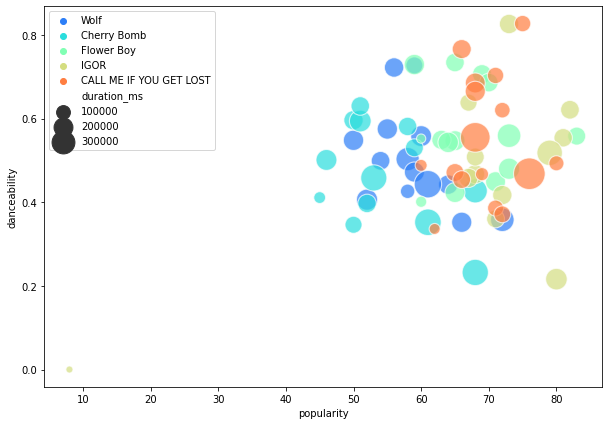

In [ ]:
#Graficamos 
plt.figure(figsize=(10,7))

ax = sns.scatterplot(data=df, x='popularity', y='danceability', 
                     hue='short_album_name', palette='rainbow', 
                     size='duration_ms', sizes=(50,1000), 
                     alpha=0.7)

# display legend without `size` attribute
h,labs = ax.get_legend_handles_labels()
ax.legend(h[1:10], labs[1:10], loc='best', title=None)

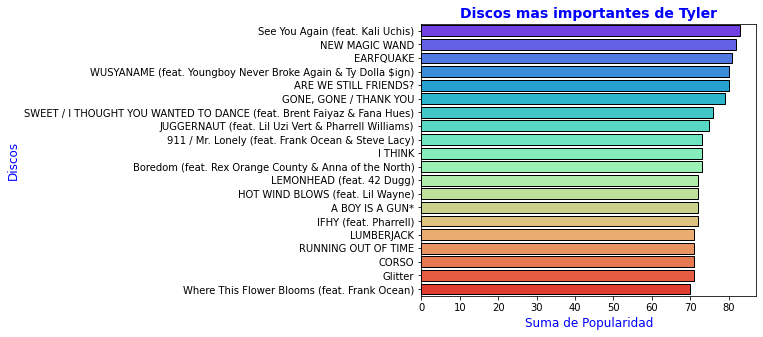

In [ ]:
#Popularidad del album
fig, ax = plt.subplots(figsize = (6, 5))
lead_track = df.groupby('track_name')['popularity'].sum().sort_values(ascending=False).head(20)
ax = sns.barplot(x=lead_track.values, y=lead_track.index, palette="rainbow", orient="h", edgecolor='black', ax=ax)
ax.set_xlabel('Suma de Popularidad', c='b', fontsize=12)
ax.set_ylabel('Discos', c='b', fontsize=12)
ax.set_title('Discos mas importantes de Tyler', c='b', fontsize=14, weight = 'bold')
plt.show()

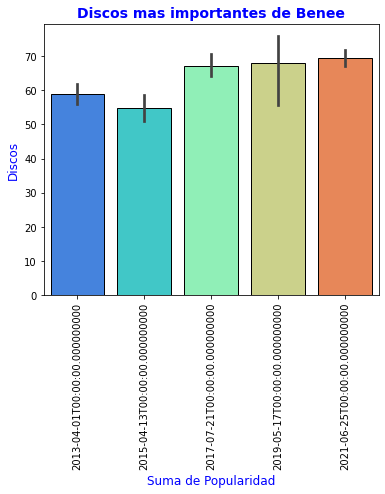

In [ ]:
#Popularidad del album
fig, ax = plt.subplots(figsize = (6, 5))
ax = sns.barplot(x=df.release_date, y=df.popularity, palette="rainbow", edgecolor='black', ax=ax)
ax.set_xlabel('Suma de Popularidad', c='b', fontsize=12)
plt.xticks(rotation=90)
ax.set_ylabel('Discos', c='b', fontsize=12)
ax.set_title('Discos mas importantes de Benee', c='b', fontsize=14, weight = 'bold')
plt.show()

## Buscar algo Especifico

Acá podemos ver los requetimientos para usar el token generado anteriormente
https://developer.spotify.com/documentation/web-api/reference/#/operations/search

Hacemos la prueba de un query trayendo una cancion en especificio a vre si el token funcions

In [ ]:
headers = {
    "Authorization": f"Bearer {access_token}"
}
endpoint = 'https://api.spotify.com/v1/search'
data = urlencode({'q':'Wonderwall', 'type':'track'})#cancion de Oasis --> Wonderwal
print(data)

lookup_url = f'{endpoint}?{data}'

r = requests.get(lookup_url, headers = headers)

print(lookup_url)
print(r.status_code)

q=Wonderwall&type=track
https://api.spotify.com/v1/search?q=Wonderwall&type=track
200


In [ ]:
#Transformamos a JSON y vemos los keys
r= r.json()
r.keys()

dict_keys(['tracks'])

In [ ]:
#Creamos el DF a partir del JSON
df = json_normalize(r)
df.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,tracks.href,tracks.items,tracks.limit,tracks.next,tracks.offset,tracks.previous,tracks.total
0,https://api.spotify.com/v1/search?query=Wonder...,"[{'album': {'album_type': 'album', 'artists': ...",20,https://api.spotify.com/v1/search?query=Wonder...,0,None,2451


## Artista en Especifico

Este query a la API nos permite traer el top de canciones mas escuchadas de un artista, hay que pasarle como variable el mercado para extraer bien la info

In [ ]:
#Headers --> la autizacion generada ocn el token que solicitamos antes
headers = {
    "Authorization": f"Bearer {access_token}"
}
endpoint = 'https://api.spotify.com/v1/artists/0Cp8WN4V8Tu4QJQwCN5Md4/top-tracks'#ver todas las canciones de Benee
data = urlencode({'limit':50,'market':'US'}) # transformamos ese diccionario en url, si no se le asgina mercado no se puede extraer
print(data)
#creamos la url a la cual conectarnos
lookup_url = f'{endpoint}?{data}'
print(lookup_url)
#Sacamos el request y vemos si es aceptado
r2 = requests.get(lookup_url, headers = headers)#.json()
print(r2)

#Lo transformamos en json
r2 = r2.json()

limit=50&market=US
https://api.spotify.com/v1/artists/0Cp8WN4V8Tu4QJQwCN5Md4/top-tracks?limit=50&market=US
<Response [200]>


In [ ]:
#Vemos las keys del json para ver si es correcto y pasarlo a DF
print(r2.keys())

dict_keys(['tracks'])


In [ ]:
#Creamos el DF a partir del JSON
df = json_normalize(r2, record_path='tracks')
df.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,artists,disc_number,duration_ms,explicit,href,id,is_local,is_playable,name,popularity,preview_url,track_number,type,uri,album.album_type,album.artists,album.external_urls.spotify,album.href,album.id,album.images,album.name,album.release_date,album.release_date_precision,album.total_tracks,album.type,album.uri,external_ids.isrc,external_urls.spotify
0,[{'external_urls': {'spotify': 'https://open.s...,1,223488,True,https://api.spotify.com/v1/tracks/3GZoWLVbmxcB...,3GZoWLVbmxcBys6g0DLFLf,False,True,Supalonely (feat. Gus Dapperton),64,None,4,track,spotify:track:3GZoWLVbmxcBys6g0DLFLf,album,[{'external_urls': {'spotify': 'https://open.s...,https://open.spotify.com/album/4KKRAmQ0ksj32l7...,https://api.spotify.com/v1/albums/4KKRAmQ0ksj3...,4KKRAmQ0ksj32l7mrgLOcF,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Hey u x,2020-11-13,day,13,album,spotify:album:4KKRAmQ0ksj32l7mrgLOcF,USUM71922597,https://open.spotify.com/track/3GZoWLVbmxcBys6...
1,[{'external_urls': {'spotify': 'https://open.s...,1,180146,False,https://api.spotify.com/v1/tracks/23TPP1eeElFf...,23TPP1eeElFfvYVznskwCY,False,True,Glitter,70,None,2,track,spotify:track:23TPP1eeElFfvYVznskwCY,single,[{'external_urls': {'spotify': 'https://open.s...,https://open.spotify.com/album/6pTMhQX8gt1xegi...,https://api.spotify.com/v1/albums/6pTMhQX8gt1x...,6pTMhQX8gt1xegiIwo3Ekb,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",FIRE ON MARZZ,2019-06-28,day,6,album,spotify:album:6pTMhQX8gt1xegiIwo3Ekb,USUM71911687,https://open.spotify.com/track/23TPP1eeElFfvYV...


In [ ]:
#Ordenamos para obtener la info que requerios y obviar el resto
df['Artist'] = 'Benee'
df = df[['Artist','name','popularity','duration_ms','explicit','disc_number','album.name','album.release_date']]
df

,Artist,name,popularity,duration_ms,explicit,disc_number,album.name,album.release_date
0,Benee,Supalonely (feat. Gus Dapperton),64,223488,True,1,Hey u x,2020-11-13
1,Benee,Glitter,70,180146,False,1,FIRE ON MARZZ,2019-06-28
2,Benee,Afterthought,62,194871,False,1,Nectar,2020-09-24
3,Benee,Doesn't Matter,66,203685,False,1,Doesn't Matter,2021-10-27
4,Benee,help herself (with BENEE),65,166613,False,1,help herself (with BENEE),2021-04-30
5,Benee,Wishful Thinking,64,213373,False,1,FIRE ON MARZZ,2019-06-28
6,Benee,Soaked,63,240946,False,1,FIRE ON MARZZ,2019-06-28
7,Benee,Find an Island,61,192613,False,1,STELLA & STEVE,2019-11-15
8,Benee,ARE YOU LETTING GO? (feat. BENEE),58,205927,False,1,ARE YOU LETTING GO? (feat. BENEE),2021-10-21
9,Benee,Happen To Me,57,231700,False,1,Hey u x,2020-11-13


Vemos de manera grafica lo que nos expresa el DF

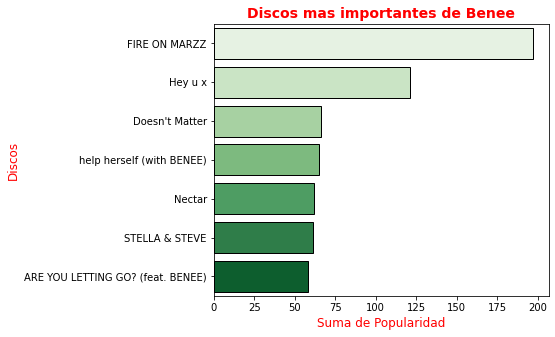

In [ ]:
fig, ax = plt.subplots(figsize = (6, 5))
lead_album = df.groupby('album.name')['popularity'].sum().sort_values(ascending=False).head(20)
ax = sns.barplot(x=lead_album.values, y=lead_album.index, palette="Greens", orient="h", edgecolor='black', ax=ax)
ax.set_xlabel('Suma de Popularidad', c='r', fontsize=12)
ax.set_ylabel('Discos', c='r', fontsize=12)
ax.set_title('Discos mas importantes de Benee', c='r', fontsize=14, weight = 'bold')
plt.show()

## Personal

In [ ]:

headers = {
    "Authorization": f"Bearer {access_token}"
          }

endpoint = 'https://api.spotify.com/v1/me/top/tracks'
data = urlencode({'limit': 50,'time_range':'medium_term'})#Mis canciones favoritas
print(data)

lookup_url = f'{endpoint}?{data}'

r = requests.get(lookup_url, headers = headers)

print(lookup_url)
print(r)
print(r.status_code)


limit=50&time_range=medium_term
https://api.spotify.com/v1/me/top/tracks?limit=50&time_range=medium_term
<Response [500]>
500
